In [1]:
import pandas as pd
import numpy as np

# 1. Load the original metadata
full_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')

# --- Step 1: Assign a single stratum to each patient ---
# We group by 'Patient ID' and create a single string for all findings.
# This makes each patient's stratum unique and comprehensive.
patient_strata = full_df.groupby('Patient ID')['Finding Labels'].apply(
    lambda x: '|'.join(sorted(list(set('|'.join(x).split('|')))))
).to_frame(name='stratum')

print(f"Total unique patients: {len(patient_strata)}")
print("Example strata for a few patients:")
print(patient_strata.head())

# --- Step 2: Define the sampling fraction ---
sampling_fraction = 0.40

# --- Step 3 & 4: Apply the formula and perform sampling ---
# We'll group our patients by their assigned stratum and then sample from each group.

sampled_patients_df = patient_strata.groupby('stratum').apply(
    lambda grp: grp.sample(
        # The number to sample is fraction * group size
        # We use np.ceil to avoid sampling 0 from very small strata
        n=int(np.ceil(len(grp) * sampling_fraction)),
        random_state=42 # for reproducibility
    )
)

# Get the list of Patient IDs that we selected
sampled_patient_ids = sampled_patients_df.index.get_level_values('Patient ID')
print(f"\nTotal patients sampled: {len(sampled_patient_ids)}")

# --- Final Step: Create the new metadata file ---
# Filter the original full dataframe to keep all images from the sampled patients.
downsized_df = full_df[full_df['Patient ID'].isin(sampled_patient_ids)]

print(f"Original number of images: {len(full_df)}")
print(f"Downsized number of images: {len(downsized_df)}")

# Save the blueprint for your new dataset
downsized_df.to_csv('Data_Entry_2017_stratified_downsized.csv', index=False)

print("\nSuccessfully created the downsized metadata file!")

Total unique patients: 30805
Example strata for a few patients:
                                     stratum
Patient ID                                  
1            Cardiomegaly|Effusion|Emphysema
2                                 No Finding
3                        Hernia|Infiltration
4                                Mass|Nodule
5           Effusion|Infiltration|No Finding


/tmp/ipykernel_13/4126115735.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_patients_df = patient_strata.groupby('stratum').apply(



Total patients sampled: 13224
Original number of images: 112120
Downsized number of images: 57302

Successfully created the downsized metadata file!


In [2]:
import pandas as pd
import cv2
import os
from tqdm import tqdm
import glob
import zipfile # The library for creating ZIP files
import shutil # For easier file management

# --- Configuration ---
csv_path = '/kaggle/working/Data_Entry_2017_stratified_downsized.csv'
base_input_dir = '/kaggle/input/data/'
# We'll create a temporary directory for processing
temp_image_dir = '/kaggle/working/temp_images/'
# The final output will be a single zip file
final_zip_path = '/kaggle/working/images.zip'
IMG_SIZE = 256

# --- Step 1: Pre-scan and Map all Image Paths ---
print("Scanning for image folders...")
image_folders = glob.glob(os.path.join(base_input_dir, 'images_*'))
print(f"Found {len(image_folders)} image folders.")

print("Creating a map of all image file paths...")
image_path_map = {
    os.path.basename(p): p
    for folder in image_folders
    for p in glob.glob(os.path.join(folder, '**', '*.png'), recursive=True)
}
print(f"Map created. Found {len(image_path_map)} total images.")

# --- Step 2: Process Images and Save to a Temporary Folder ---
df = pd.read_csv(csv_path)
os.makedirs(temp_image_dir, exist_ok=True)

print(f"\nProcessing and resizing {len(df)} images...")
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_filename = row['Image Index']
    source_path = image_path_map.get(image_filename)
    if source_path:
        destination_path = os.path.join(temp_image_dir, image_filename)
        try:
            img = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
                cv2.imwrite(destination_path, resized_img)
        except Exception as e:
            print(f"Error processing {source_path}: {e}")

print("Image resizing complete.")

# --- Step 3: Create a single ZIP file from the processed images ---
print(f"\nCreating a single ZIP file at {final_zip_path}...")
with zipfile.ZipFile(final_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(temp_image_dir):
        for file in tqdm(files, desc="Zipping files"):
            zipf.write(os.path.join(root, file), arcname=file)

print("ZIP file created successfully.")

# --- Step 4: Clean up the temporary directory ---
print("Cleaning up temporary image files...")
shutil.rmtree(temp_image_dir)
print("Cleanup complete.")

print("\n--- Data Preparation Complete ---")
print(f"Your final output files in /kaggle/working/ are:")
print(f"1. {os.path.basename(csv_path)}")
print(f"2. {os.path.basename(final_zip_path)}")

Scanning for image folders...
Found 12 image folders.
Creating a map of all image file paths...
Map created. Found 112120 total images.

Processing and resizing 57302 images...


100%|██████████| 57302/57302 [24:23<00:00, 39.14it/s]


Image resizing complete.

Creating a single ZIP file at /kaggle/working/images.zip...


Zipping files: 100%|██████████| 57302/57302 [01:26<00:00, 665.46it/s]


ZIP file created successfully.
Cleaning up temporary image files...
Cleanup complete.

--- Data Preparation Complete ---
Your final output files in /kaggle/working/ are:
1. Data_Entry_2017_stratified_downsized.csv
2. images.zip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-pastel")

# Load your downsized metadata file from the /kaggle/working/ directory
csv_path = '/kaggle/working/Data_Entry_2017_stratified_downsized.csv'
df = pd.read_csv(csv_path)

print("Successfully loaded the dataset.")
print(f"The dataset contains {len(df)} image records.")
df.head()

Successfully loaded the dataset.
The dataset contains 57302 image records.


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
1,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
2,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
3,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
4,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN


In [4]:
# Calculate the number of unique patients
unique_patient_count = df['Patient ID'].nunique()

print(f"Total number of images in the downsized dataset: {len(df)}")
print(f"Total number of unique patients considered: {unique_patient_count}")

Total number of images in the downsized dataset: 57302
Total number of unique patients considered: 13224


One-hot encoding the labels...
Done.


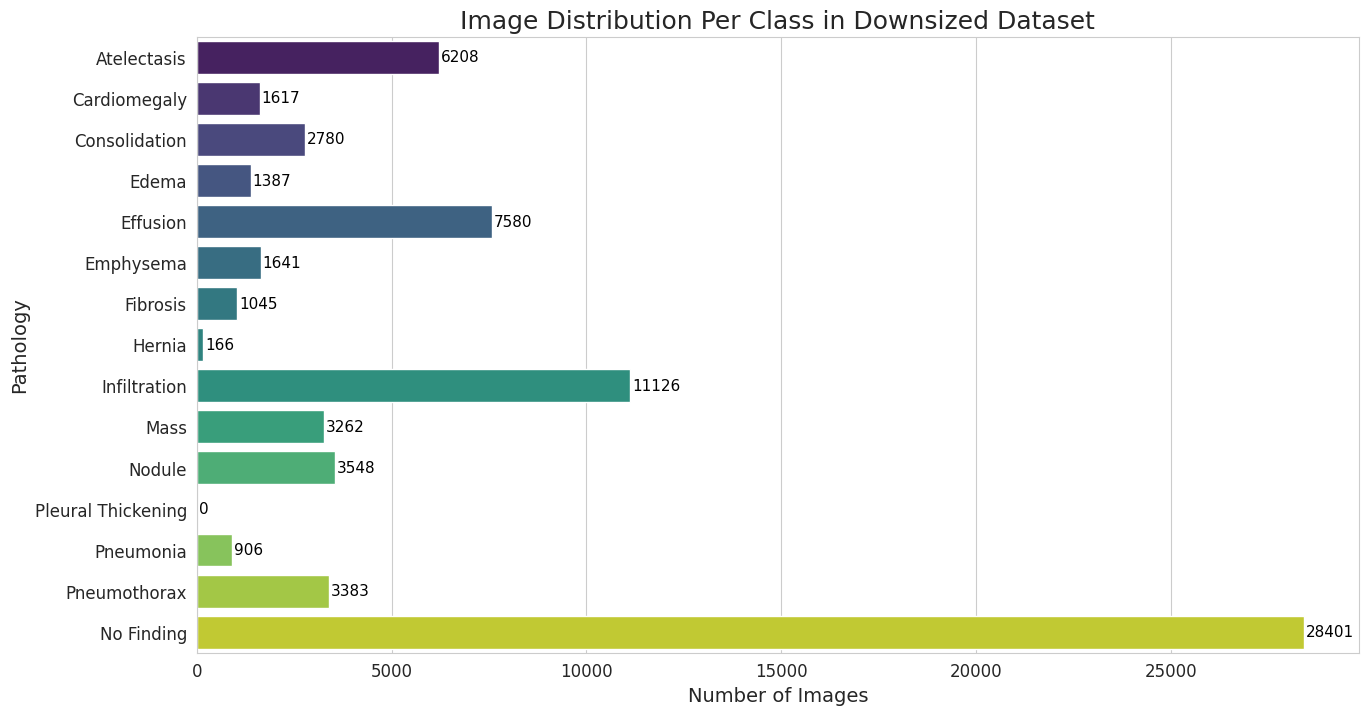

In [5]:
# Create a list of all unique pathologies
# First, get all labels and split them, then find the unique ones
all_labels = set(label for finding in df['Finding Labels'] for label in finding.split('|'))
# The official dataset has 14 pathologies + 'No Finding'
# We'll hardcode them to ensure consistency and correct order
all_labels_sorted = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'No Finding'
]

print("One-hot encoding the labels...")
# Create a new column for each pathology
for label in all_labels_sorted:
    # Note: Pleural_Thickening has a space in the original, so we handle that if needed
    # but the split('|') method should handle it. The label name here is for the column.
    clean_label = label.replace('_', ' ')
    df[label] = df['Finding Labels'].apply(lambda x: 1 if clean_label in x else 0)

print("Done.")

# Calculate the number of images per class
# We'll sum up the one-hot encoded columns
per_class_counts = df[all_labels_sorted].sum()

# Create the plot
plt.figure(figsize=(15, 8))
sns.barplot(x=per_class_counts.values, y=per_class_counts.index, palette='viridis')
plt.title('Image Distribution Per Class in Downsized Dataset', fontsize=18)
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Pathology', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for i, v in enumerate(per_class_counts.values):
    plt.text(v + 50, i, str(v), color='black', va='center', fontsize=11)
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


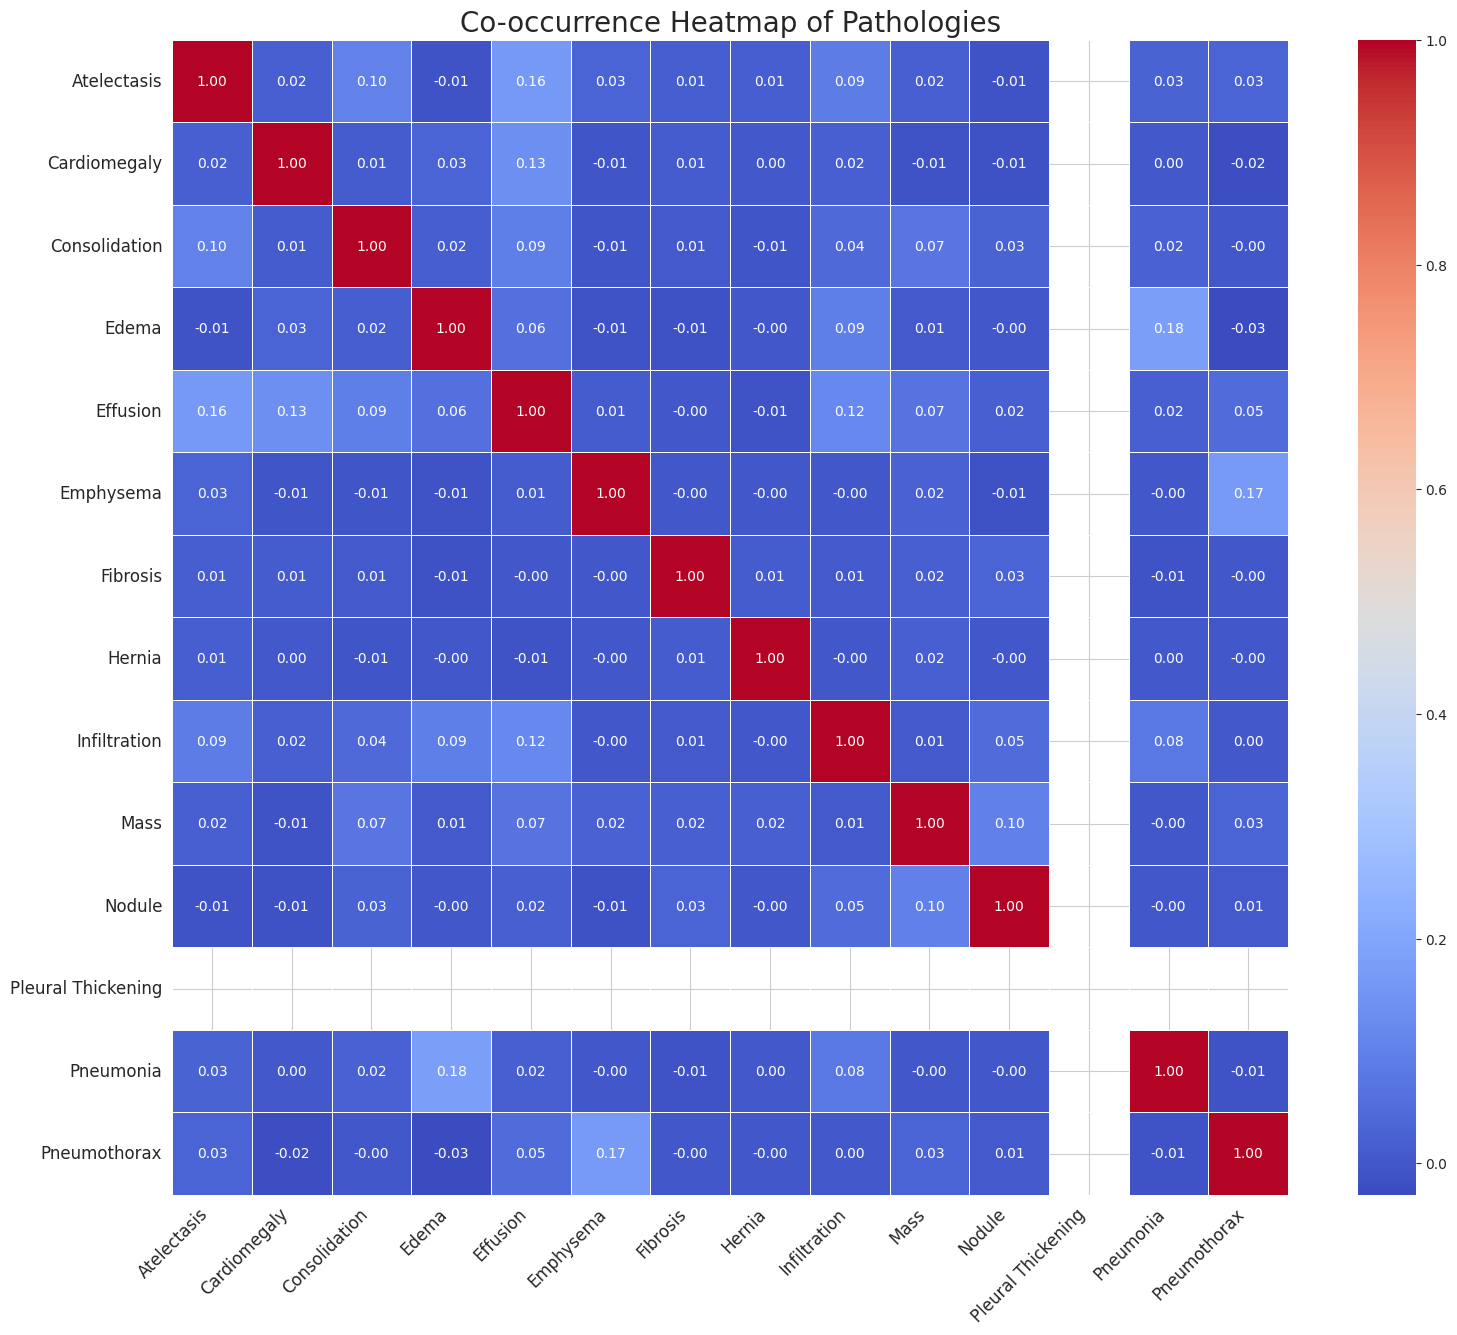

In [6]:
# We are interested in the correlation between actual diseases, so we exclude 'No Finding'
pathology_columns = [col for col in all_labels_sorted if col != 'No Finding']

# Calculate the correlation matrix
correlation_matrix = df[pathology_columns].corr()

# Create the heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f", # Format to two decimal places
    cmap='coolwarm',
    linewidths=.5
)
plt.title('Co-occurrence Heatmap of Pathologies', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

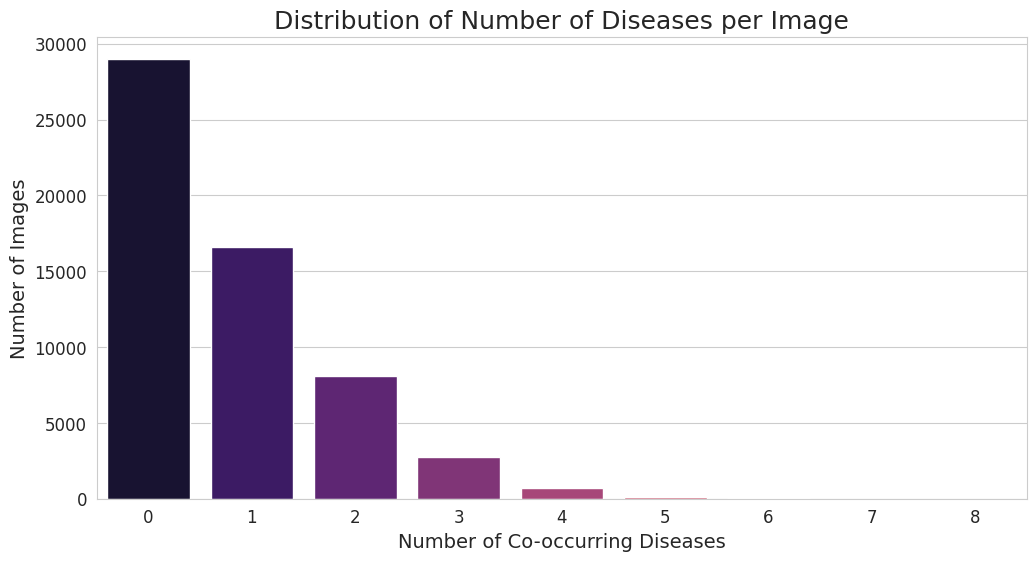

In [7]:
# Create a new column for the total number of diseases in each image
# We again exclude 'No Finding' from the count
df['Disease Count'] = df[pathology_columns].sum(axis=1)

# Create the count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='Disease Count', data=df, palette='magma')
plt.title('Distribution of Number of Diseases per Image', fontsize=18)
plt.xlabel('Number of Co-occurring Diseases', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [8]:
import pandas as pd

# Load your downsized dataset again to ensure we are working with a clean copy
df = pd.read_csv('/kaggle/working/Data_Entry_2017_stratified_downsized.csv')

# --- Step 1: Let's Diagnose Using Your Example ---
example_image = '00000104_000.png'
# Use .loc to safely access the data
finding_label_from_csv = df.loc[df['Image Index'] == example_image, 'Finding Labels'].iloc[0]

print(f"--- Diagnosis based on your example image: '{example_image}' ---")
print(f"The exact string found in the CSV is: '{finding_label_from_csv}'")
print("------------------------------------------------------------------")


# --- Step 2: The Robust Fix (Case-Insensitive) ---
# We will now re-run the entire one-hot encoding process with the improved logic.

print("Applying a robust, case-insensitive one-hot encoding for all labels...")

all_labels_sorted = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'No Finding'
]

# Loop through each label and apply the case-insensitive check
for label in all_labels_sorted:
    # Prepare the label we are searching for (e.g., 'Pleural_Thickening' -> 'pleural thickening')
    clean_label_to_find = label.replace('_', ' ').lower()
    
    # Create the column by converting the 'Finding Labels' to lowercase before checking
    # The .str.lower() is the key part of the fix
    df[label] = df['Finding Labels'].str.lower().apply(
        lambda finding_string: 1 if clean_label_to_find in finding_string else 0
    )

print("\nAll labels have been re-encoded with the robust method.")

# --- Step 3: Verify the Fix ---
new_count = df['Pleural_Thickening'].sum()
print(f"\nVerification successful!")
print(f"The new, correct count for 'Pleural_Thickening' is: {new_count}")

--- Diagnosis based on your example image: '00000104_000.png' ---
The exact string found in the CSV is: 'Pleural_Thickening'
------------------------------------------------------------------
Applying a robust, case-insensitive one-hot encoding for all labels...

All labels have been re-encoded with the robust method.

Verification successful!
The new, correct count for 'Pleural_Thickening' is: 0


In [9]:
import pandas as pd

print("--- Starting Deep Forensic Analysis ---")
print("We will inspect the data and the strings step-by-step.")

# --- Step 1: Load the data fresh into a new dataframe ---
# This ensures we're not using a stale version from memory.
csv_path = '/kaggle/working/Data_Entry_2017_stratified_downsized.csv'
try:
    debug_df = pd.read_csv(csv_path)
    print(f"Successfully loaded '{csv_path}'")
except Exception as e:
    print(f"Fatal Error: Could not load the CSV file. Error: {e}")
    # Stop here if we can't load the file
    exit()

# --- Step 2: Isolate the specific row you found ---
example_image_index = '00000104_000.png'
example_row = debug_df[debug_df['Image Index'] == example_image_index]

# --- Step 3: Analyze the row and the raw string ---
if example_row.empty:
    print(f"\n--- DIAGNOSIS: PROBLEM FOUND ---")
    print(f"The example image '{example_image_index}' was NOT FOUND in your downsized CSV file.")
    print("This is the most likely source of the confusion. You might have seen it in the original full dataset,")
    print("but the stratified sampling process did not happen to select this specific image.")

else:
    # The row was found, so let's inspect its 'Finding Labels' string
    raw_label_string = example_row['Finding Labels'].iloc[0]
    print(f"\n--- Analysis of Your Example Row ---")
    print(f"Image Index: {example_image_index}")
    # The repr() function is excellent because it reveals hidden characters
    print(f"The 'repr' of the raw string is: {repr(raw_label_string)}")

    # Step 4: Manually check this one string for the substring
    print("\n--- Manual Check of This Single String ---")
    target_substring = 'pleural thickening'
    string_to_check = raw_label_string.lower()
    is_present = target_substring in string_to_check

    print(f"1. String converted to lowercase: '{string_to_check}'")
    print(f"2. Checking if the target substring '{target_substring}' is present...")
    print(f"3. Result of check: {is_present}")

    if not is_present:
        print("\n--- DIAGNOSIS: PROBLEM FOUND ---")
        print("The substring 'pleural thickening' was NOT found in this example's label string.")
        print("This means the label for this image might be spelled differently (e.g., a typo) or contains an unusual character.")


# --- Step 5: Global Search Across ALL Rows ---
# This ignores the previous code and just searches the whole file from scratch.
print("\n--- Global Search Across Entire File ---")
print("Searching every row for 'pleural thickening' (case-insensitive)...")

found_instances = []
target_substring = 'pleural thickening'

# Ensure the column is treated as string type to use .str accessor
debug_df['Finding Labels'] = debug_df['Finding Labels'].astype(str)

# A fast, vectorized way to search
found_df = debug_df[debug_df['Finding Labels'].str.lower().str.contains(target_substring, na=False)]

if found_df.empty:
    print("\n--- FINAL DIAGNOSIS ---")
    print("GLOBAL SEARCH RESULT: The substring 'pleural thickening' was definitively NOT FOUND in ANY row of your downsized CSV file.")
    print("This indicates that by chance, the stratified sampling process did not select any patients with this specific finding.")
    print("While rare, this is possible if the finding was already very uncommon in the original dataset.")
else:
    print("\n--- FINAL DIAGNOSIS ---")
    print(f"GLOBAL SEARCH RESULT: Found {len(found_df)} total instances of 'Pleural Thickening'.")
    print("Here are the first 5 examples found:")
    print(found_df[['Image Index', 'Finding Labels']].head())
    print("\nThis means the string DOES exist in the CSV, and there was a bug in the previous counting logic.")
    print("The code in this cell should now be the source of truth.")

--- Starting Deep Forensic Analysis ---
We will inspect the data and the strings step-by-step.
Successfully loaded '/kaggle/working/Data_Entry_2017_stratified_downsized.csv'

--- Analysis of Your Example Row ---
Image Index: 00000104_000.png
The 'repr' of the raw string is: 'Pleural_Thickening'

--- Manual Check of This Single String ---
1. String converted to lowercase: 'pleural_thickening'
2. Checking if the target substring 'pleural thickening' is present...
3. Result of check: False

--- DIAGNOSIS: PROBLEM FOUND ---
The substring 'pleural thickening' was NOT found in this example's label string.
This means the label for this image might be spelled differently (e.g., a typo) or contains an unusual character.

--- Global Search Across Entire File ---
Searching every row for 'pleural thickening' (case-insensitive)...

--- FINAL DIAGNOSIS ---
GLOBAL SEARCH RESULT: The substring 'pleural thickening' was definitively NOT FOUND in ANY row of your downsized CSV file.
This indicates that by

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-pastel")

# --- Load and Prepare Data ---
csv_path = '/kaggle/working/Data_Entry_2017_stratified_downsized.csv'
df = pd.read_csv(csv_path)

# Define all pathologies and 'No Finding'
all_14_original_labels = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
    'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]
# Create a list of the 13 pathologies we are using (excluding Pleural_Thickening)
final_13_labels = [label for label in all_14_original_labels if label != 'Pleural_Thickening']

# Create the full list of categories to plot, including 'No Finding'
labels_to_plot = final_13_labels + ['No Finding']

# --- Perform robust one-hot encoding for all categories ---
for label in labels_to_plot:
    # Handle the space in 'Pleural Thickening' and 'No Finding'
    clean_label_to_find = label.replace('_', ' ').lower()
    df[label] = df['Finding Labels'].str.lower().apply(
        lambda finding_string: 1 if clean_label_to_find in str(finding_string) else 0
    )

print("Data is ready for plotting with 13 pathologies + 'No Finding'.")

Data is ready for plotting with 13 pathologies + 'No Finding'.


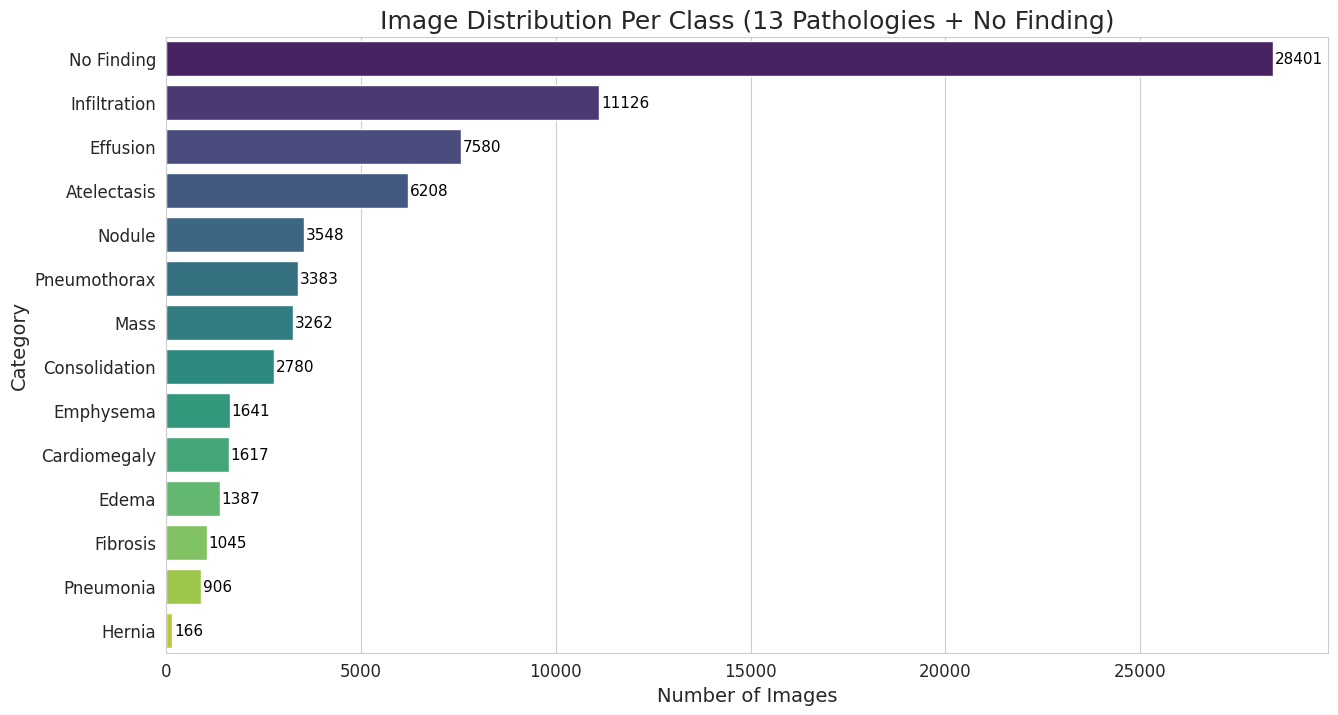

In [11]:
# Calculate the number of images per class for all 14 categories
per_class_counts = df[labels_to_plot].sum().sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(15, 8))
sns.barplot(x=per_class_counts.values, y=per_class_counts.index, palette='viridis')
plt.title('Image Distribution Per Class (13 Pathologies + No Finding)', fontsize=18)
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add count labels to the bars
for i, v in enumerate(per_class_counts.values):
    plt.text(v + 50, i, str(v), color='black', va='center', fontsize=11)
    
plt.show()

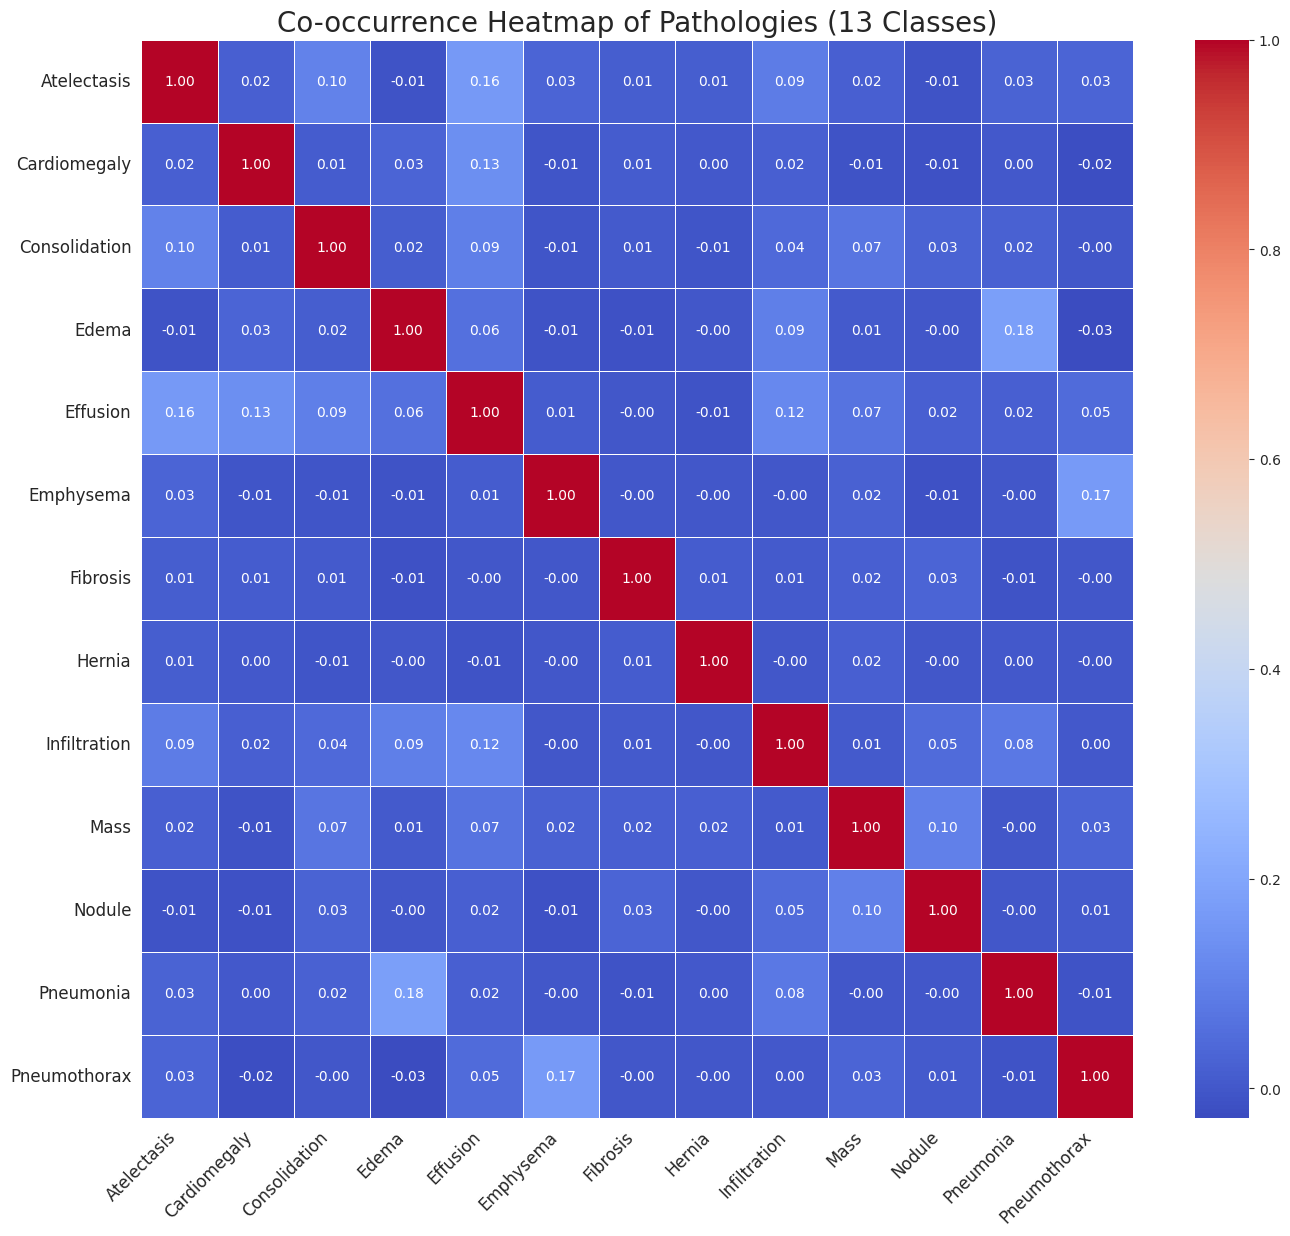

In [12]:
# The heatmap is most useful when showing relationships between diseases only
plt.figure(figsize=(16, 14))
sns.heatmap(
    df[final_13_labels].corr(), # Using the list of 13 pathologies
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5
)
plt.title('Co-occurrence Heatmap of Pathologies (13 Classes)', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

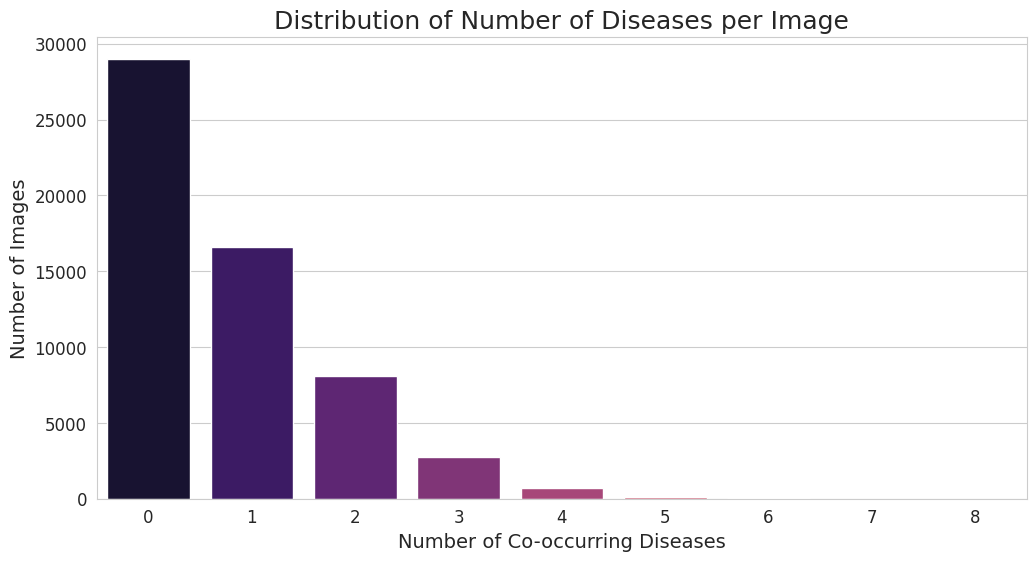

In [13]:
# This code correctly calculates the number of *diseases*, so 'No Finding' cases have a count of 0.
df['Disease Count'] = df[final_13_labels].sum(axis=1)

# Create the count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='Disease Count', data=df, palette='magma')
plt.title('Distribution of Number of Diseases per Image', fontsize=18)
plt.xlabel('Number of Co-occurring Diseases', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

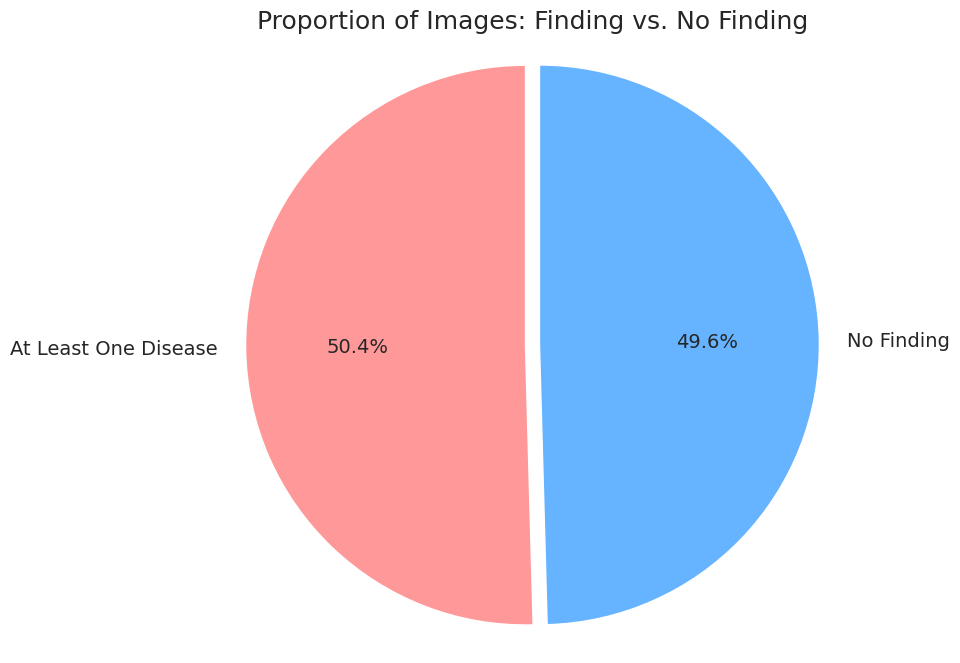

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-pastel")

# --- Step 1: Ensure the dataframe is loaded and prepared ---
# This re-uses the logic from before to make this cell self-contained.
csv_path = '/kaggle/working/Data_Entry_2017_stratified_downsized.csv'
df = pd.read_csv(csv_path)

# We only need to create the 'No Finding' column for this plot
df['No Finding'] = df['Finding Labels'].str.lower().apply(
    lambda finding_string: 1 if 'no finding' in str(finding_string) else 0
)

# --- Step 2: Calculate the counts for the two categories ---

# Count of images with 'No Finding'
no_finding_count = df['No Finding'].sum()

# Count of images with at least one disease is the rest
any_disease_count = len(df) - no_finding_count

# --- Step 3: Prepare data and create the pie chart ---

# Data for the pie chart
labels = ['At Least One Disease', 'No Finding']
sizes = [any_disease_count, no_finding_count]
colors = ['#ff9999','#66b3ff'] # Soft red and blue colors
explode = (0.05, 0)  # Explode the first slice slightly to highlight it

plt.figure(figsize=(10, 8))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%', # Format to show percentages with one decimal place
    startangle=90,
    textprops={'fontsize': 14}
)

plt.title('Proportion of Images: Finding vs. No Finding', fontsize=18)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()